
I'm using recurrent neural nets (RNNs) for a slightly non-standard application: image classification, because it will be capable of handling variable length input ie. you could just input 1/5th of the image and the model would still provide accurate classifications.

In [ ]:
import torch
import torch.nn as nn
from torch import optim # We will be using the ADAM optimizer
from torchvision import datasets
from torchvision.transforms import ToTensor

import random
import matplotlib.pyplot as plt


train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.FashionMNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()

)

Let's plot a few images just to get an idea of what we are working with. Our goal in this notebook is to build a model which has two stages:
1.  an RNN
2. a linear layer

The RNN should be able to handle an arbitrary number of rows of the image (such as the first $10$ rows or all rows) and outputs a representation that is sent to the linear layer. The output of the linear layer will be a vector representing class probabilities.

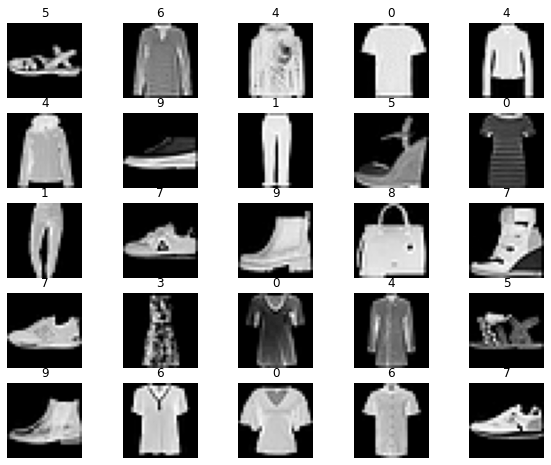

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(10,8))
for i in range(axs.shape[0]):
  for j in range(axs.shape[1]):
    rand_idx = random.randint(0, len(train_data))
    img, label = train_data[rand_idx]
    axs[i,j].imshow(img.squeeze(), cmap='gray')
    axs[i,j].set_title(str(label))
    axs[i,j].axis("off")

In [ ]:
from torch.utils.data import DataLoader
dataloaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=128, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [ ]:
imgs, labels = next(iter(dataloaders['train']))
print(imgs.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
model = nn.RNN(input_size=28, hidden_size=55, batch_first=True) #batch is not the first axis by default for RNNs
print(model)

RNN(28, 55, batch_first=True)


In [ ]:
for param in model.parameters():
  print(param.shape)

torch.Size([55, 28])
torch.Size([55, 55])
torch.Size([55])
torch.Size([55])


Image size: torch.Size([1, 15, 28])


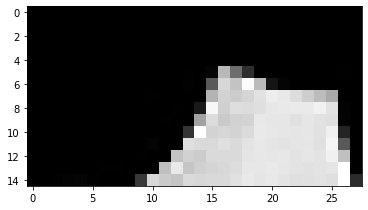

In [ ]:
img = imgs[0,:,:15,:]
print("Image size:", img.shape)
plt.imshow(img.squeeze(), cmap='gray')

In [ ]:
all_hidden_states, final_hidden_state = model(img)
print(all_hidden_states.shape) #15, 55
print(final_hidden_state.shape) # 1, 55

torch.Size([1, 15, 55])
torch.Size([1, 1, 55])


In [ ]:
torch.allclose(all_hidden_states[0, -1], final_hidden_state[0])

True

Now, let's pass in all 28 rows of a FashionMNIST image. Note that we don't have to change the code at all since RNNs can handle a sequence of varying length.

Image size: torch.Size([1, 28, 28])


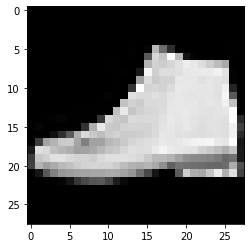

In [ ]:
img = imgs[0,:,:28,:]
print("Image size:", img.shape)
plt.imshow(img.squeeze(), cmap='gray')

In [ ]:
all_hidden_states, final_hidden_state = model(img)
print(all_hidden_states.shape) #28, 55
print(final_hidden_state.shape) # 1, 55

torch.Size([1, 28, 55])
torch.Size([1, 1, 55])


This time, we have 28 hidden states (one for each input token).

In [ ]:
input_size = 28 # each input token is a row of a FashionMNIST image so 28 pixels
hidden_size=128 # hidden representation size
num_layers = 2  # two-layer LSTM
num_classes = 10
num_epochs=4
learning_rate= 0.01

Let's build our model. Torch's LSTM returns three tensors: 
1. all hidden states
2. the final hidden state
3. the final cell state

In [ ]:
class RNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    all_hidden, (h_n, c_n) = self.lstm(x)
    # there are two final hidden states (one for each LSTM)
    # let's just use the second hidden state
    out = self.fc(h_n[-1]) 
    return out


model = RNN(input_size, hidden_size, num_layers, num_classes)
print(model)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


## Training the Model

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_step = len(dataloaders['train'])
model = model.cuda() 

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloaders['train']):
        images = images.cuda()
        labels = labels.cuda()
        # Forward pass
        outputs = model(images.squeeze()) # remove singleton dimension
        loss = loss_func(outputs, labels)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.2f}' 
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/4], Step [100/469], Loss: 0.76
Epoch [1/4], Step [200/469], Loss: 0.48
Epoch [1/4], Step [300/469], Loss: 0.69
Epoch [1/4], Step [400/469], Loss: 0.57
Epoch [2/4], Step [100/469], Loss: 0.46
Epoch [2/4], Step [200/469], Loss: 0.45
Epoch [2/4], Step [300/469], Loss: 0.57
Epoch [2/4], Step [400/469], Loss: 0.42
Epoch [3/4], Step [100/469], Loss: 0.35
Epoch [3/4], Step [200/469], Loss: 0.36
Epoch [3/4], Step [300/469], Loss: 0.52
Epoch [3/4], Step [400/469], Loss: 0.29
Epoch [4/4], Step [100/469], Loss: 0.40
Epoch [4/4], Step [200/469], Loss: 0.34
Epoch [4/4], Step [300/469], Loss: 0.28
Epoch [4/4], Step [400/469], Loss: 0.19


## Testing the Model
The loss looks decent enough! Let's test the model now.

In [ ]:
model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in dataloaders['test']:
        images = images.cuda()
        labels = labels.cuda()
        images = images.reshape(-1, 28, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test accuracy: {100 * correct / total}%')

Test accuracy: 87.18%


Not too bad! We get ~88% accuracy on FashionMNIST where the pixels are presented sequentially, which is comparable to what we got using regular dense architectures.

## Sequences of Varying Length
An advantage of RNN-based classification for images is that since RNNs work for variable-length inputs, it allows for declaring a class label even if the input is partially available (for example, if only the top one-third of the pixels were rasterized). Let's see how this would work.

In [ ]:
imgs, labels = next(iter(dataloaders['test']))
print(imgs.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


Image size: torch.Size([1, 5, 28])


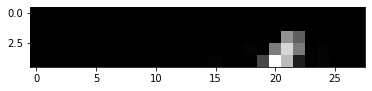

In [ ]:
number_of_rows = 5
idx = 3
img = imgs[idx,:,:number_of_rows,:]
label = labels[idx].item()
print("Image size:", img.shape)
plt.imshow(img.squeeze(), cmap='gray')

Let's see how the RNN handles just seeing the first 5 rows of this image.

Text(0.5, 1.0, 'Prediction: 5, Label: 5')

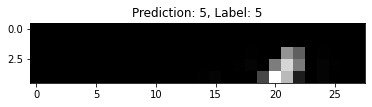

In [ ]:
output = model(img.cuda())
prediction = torch.argmax(output).cpu().item()
plt.imshow(img.squeeze(), cmap='gray')
plt.title("Prediction: {}, Label: {}".format(prediction, label))

It's predicted the correct class label of 5. 